why to do Segmentation?

Because you can’t treat every customer the same way with the same content, same channel, same importance. They will find another option which understands them better.

# RFM
RFM stands for Recency - Frequency - Monetary Value
Theoretically we will have segments like below:
#### Low Value: Customers who are less active than others, not very frequent buyer/visitor and generates very low - zero - maybe negative revenue.
#### Mid Value: In the middle of everything. Often using our platform (but not as much as our High Values), fairly frequent and generates moderate revenue.
#### High Value: The group we don’t want to lose. High Revenue, Frequency and low Inactivity.

#### 1. Recency : to find recency - we need to find out most recent purchase date of each customer and see how many days they are inactive for. After having no. of inactive days for each customer, we will apply k-means clustering to assign customers a recency score.

In [1]:
import pandas as pd
import numpy as np 

%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from datetime import datetime as dt

In [3]:
data = pd.read_csv('OnlineRetail2.csv')

In [4]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data_kol = data[data['Dist'] == 'Kolakata']

In [5]:
data_kol.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Dist
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,Kolakata
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,Kolakata
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,Kolakata
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,Kolakata
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,Kolakata


In [6]:
#create 3m and 6m dataframes
df_3m = 

SyntaxError: invalid syntax (<ipython-input-6-4e11ae16f710>, line 2)

#### calculating recency 

In [7]:
# create a generic user dataframe to keep CustomerID and NEW segmentation scores

In [8]:
df_users = pd.DataFrame(data_kol['CustomerID'].unique(),columns = ['CustomerID'])

In [9]:
df_users.shape

(3951, 1)

In [10]:
df_users.head()

,CustomerID
0,17850.0
1,13047.0
2,13748.0
3,15100.0
4,15291.0


In [11]:
# get the maximum purchase date for each customer and create a dataframe with it 

In [12]:
df_max_purchase = data_kol.groupby('CustomerID').agg({'InvoiceDate':'max'}).reset_index()
df_max_purchase.columns = ['CustomerID','MaxPurchaseDate']
df_max_purchase.head()

,CustomerID,MaxPurchaseDate
0,12346.0,2011-01-18 10:17:00
1,12747.0,2011-12-07 14:34:00
2,12748.0,2011-12-09 12:20:00
3,12749.0,2011-12-06 09:56:00
4,12820.0,2011-12-06 15:12:00


In [13]:
# we take our observation point as the max invoice date in our dataset


In [14]:
df_max_purchase['Recency'] = (df_max_purchase['MaxPurchaseDate'].max() - df_max_purchase['MaxPurchaseDate']).dt.days

In [15]:
df_max_purchase # has't bought in 325 days

,CustomerID,MaxPurchaseDate,Recency
0,12346.0,2011-01-18 10:17:00,325
1,12747.0,2011-12-07 14:34:00,1
2,12748.0,2011-12-09 12:20:00,0
3,12749.0,2011-12-06 09:56:00,3
4,12820.0,2011-12-06 15:12:00,2
...,...,...,...
3945,18280.0,2011-03-07 09:52:00,277
3946,18281.0,2011-06-12 10:53:00,180
3947,18282.0,2011-12-02 11:43:00,7
3948,18283.0,2011-12-06 12:02:00,3


In [16]:
# merge this dataframe to our new user dataframe

df_user = pd.merge(df_users,df_max_purchase[['CustomerID','Recency']],on= 'CustomerID')

In [17]:
df_user.shape

(3950, 2)

In [18]:
df_user.describe()

,CustomerID,Recency
count,3950.000000,3950.000000
mean,15562.029367,90.778481
std,1576.848325,100.230349
min,12346.000000,0.000000
25%,14208.250000,16.000000
50%,15571.500000,49.000000
75%,16913.750000,142.000000
max,18287.000000,373.000000


#### We see that even though the average is 90 day recency, median is 49.

### We are going to apply K-means clustering to assign a recency score. But we should tell how many clusters we need to K-means algorithm. To find it out, we will apply Elbow Method. Elbow Method simply tells the optimal cluster number for optimal inertia.

In [19]:
from sklearn.cluster import KMeans
sse ={}
df_recency = df_user[['Recency']] # made it a 2d array with one more []

for k in range(1,10): # 10 not inncluded
    kmean = KMeans(n_clusters = k, max_iter = 1000)
    kmean.fit(df_recency)
    
    #df_recency['clusters'] = kmean.labels_
    sse[k] = kmean.inertia_



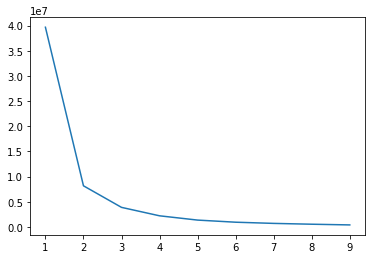

In [20]:
plt.plot(list(sse.keys()), list(sse.values()))


### Here it looks like 3 is the optimal one. Based on business requirements, we can go ahead with less or more clusters. We will be selecting 4 for this example:

In [21]:
# build 4 clusters for recency and add it to dataframe

In [22]:
kmeans = KMeans(n_clusters = 4)
kmeans.fit(df_recency)
df_user['RecencyCluster'] = kmeans.predict(df_user[['Recency']])


In [23]:
df_user.head()

,CustomerID,Recency,RecencyCluster
0,17850.0,301,0
1,13047.0,31,1
2,13748.0,95,3
3,15100.0,329,0
4,15291.0,25,1


In [24]:
df_user.groupby('RecencyCluster').agg({'Recency':'describe'})

Recency                                                      \
                 count        mean        std    min     25%    50%    75%   
RecencyCluster                                                               
0                478.0  304.393305  41.183489  245.0  266.25  300.0  336.0   
1               1950.0   17.488205  13.237058    0.0    6.00   16.0   28.0   
2                570.0  184.436842  31.856230  131.0  156.00  184.0  211.0   
3                952.0   77.567227  22.743569   48.0   59.00   72.0   93.0   

                       
                  max  
RecencyCluster         
0               373.0  
1                47.0  
2               244.0  
3               130.0

#### we will add a function order_cluster(). K-means assings clusters as nuimbers but not in an 
####  an ordered way. we can't say cluster  0 is the worst or cluster 4 is the best, order_cluster() does this for us.

In [25]:
# function for ordering cluster numbers 
def order_cluster(cluster_field_name,target_field_name,df,ascending):
    #new_cluster_field_name = 'new' + cluster_field_name
    df_new = df.groupby(cluster_field_name).agg({target_field_name:'mean'}).reset_index()
    df_new = df_new.sort_values(target_field_name,ascending = ascending).reset_index(drop = True)
    df_new['rank'] = df_new.index
    df_final = pd.merge(df_user,df_new[['rank',cluster_field_name]], on = cluster_field_name)
    df_final.drop(cluster_field_name,axis = 1,inplace = True)
    df_final.rename(columns = {'rank': cluster_field_name},inplace = True)
    return df_final   
    

In [26]:
df_user = order_cluster('RecencyCluster','Recency', df_user,False) 

In [27]:
df_user.groupby('RecencyCluster').agg({'Recency':'describe'})

Recency                                                      \
                 count        mean        std    min     25%    50%    75%   
RecencyCluster                                                               
0                478.0  304.393305  41.183489  245.0  266.25  300.0  336.0   
1                570.0  184.436842  31.856230  131.0  156.00  184.0  211.0   
2                952.0   77.567227  22.743569   48.0   59.00   72.0   93.0   
3               1950.0   17.488205  13.237058    0.0    6.00   16.0   28.0   

                       
                  max  
RecencyCluster         
0               373.0  
1               244.0  
2               130.0  
3                47.0

## Frequency


In [28]:
df_freq = data_kol.groupby('CustomerID').agg({'InvoiceDate':'count'}).reset_index()
df_freq.columns = ['CustomerID','Frequency']
df_freq

,CustomerID,Frequency
0,12346.0,2
1,12747.0,103
2,12748.0,4642
3,12749.0,231
4,12820.0,59
...,...,...
3945,18280.0,10
3946,18281.0,7
3947,18282.0,13
3948,18283.0,756


In [29]:
# add this to main dataframe

df_user = pd.merge(df_user,df_freq, on = 'CustomerID')
df_user

,CustomerID,Recency,RecencyCluster,Frequency
0,17850.0,301,0,312
1,15100.0,329,0,6
2,18074.0,373,0,13
3,16250.0,260,0,24
4,13747.0,373,0,1
...,...,...,...,...
3945,14143.0,133,1,7
3946,16147.0,133,1,22
3947,15149.0,133,1,23
3948,15776.0,132,1,18


In [30]:
# k - means

kmeans = KMeans(n_clusters = 4)
kmeans.fit(df_user[['Frequency']])
df_user['FrequencyCluster'] = kmeans.predict(df_user[['Frequency']])
df_user  = order_cluster('FrequencyCluster','Frequency',df_user,True)



In [31]:
df_user

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster
0,17850.0,301,0,312,1
1,15808.0,305,0,210,1
2,13047.0,31,3,196,1
3,14688.0,7,3,359,1
4,16029.0,38,3,274,1
...,...,...,...,...,...
3945,14056.0,0,3,1128,2
3946,14456.0,4,3,977,2
3947,12748.0,0,3,4642,3
3948,17841.0,1,3,7983,3


In [32]:
df_user.groupby('FrequencyCluster').agg({'Frequency':'describe'})

Frequency                                                    \
                     count         mean          std     min     25%     50%   
FrequencyCluster                                                               
0                   3496.0    49.525744    44.954212     1.0    15.0    33.0   
1                    429.0   331.221445   133.856510   191.0   228.0   287.0   
2                     22.0  1313.136364   505.934524   872.0   988.5  1140.0   
3                      3.0  5917.666667  1805.062418  4642.0  4885.0  5128.0   

                                  
                     75%     max  
FrequencyCluster                  
0                   73.0   190.0  
1                  399.0   803.0  
2                 1452.0  2782.0  
3                 6555.5  7983.0

In [33]:
# so cluster 3 represents 3 customers with min frequency of 4642 and max frequency of 7983

## Revenue

In [34]:
data_kol['Revenue'] = data_kol['UnitPrice'] * data_kol['Quantity']

df_revenue  =data_kol.groupby('CustomerID').agg({'Revenue':'sum'}).reset_index()

df_user = pd.merge(df_user,df_revenue, on = 'CustomerID')

<ipython-input-34-04e914991f70>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_kol['Revenue'] = data_kol['UnitPrice'] * data_kol['Quantity']


In [35]:
df_user

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,17850.0,301,0,312,1,5288.63
1,15808.0,305,0,210,1,3724.77
2,13047.0,31,3,196,1,3079.10
3,14688.0,7,3,359,1,5107.38
4,16029.0,38,3,274,1,50992.61
...,...,...,...,...,...,...
3945,14056.0,0,3,1128,2,8124.40
3946,14456.0,4,3,977,2,3047.63
3947,12748.0,0,3,4642,3,29072.10
3948,17841.0,1,3,7983,3,40340.78


In [36]:
# k-means

kmeans = KMeans(n_clusters = 4)
kmeans.fit(df_user[['Revenue']])
df_user['Revenue_cluster'] = kmeans.predict(df_user[['Revenue']])


In [37]:
df_user = order_cluster('Revenue_cluster','Revenue',df_user,True)

In [38]:
#df_user.drop(columns = 'Revenue_cat',inplace = True)
df_user

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,Revenue_cluster
0,17850.0,301,0,312,1,5288.63,1
1,14688.0,7,3,359,1,5107.38,1
2,13767.0,1,3,399,1,16945.71,1
3,15513.0,30,3,314,1,14520.08,1
4,14849.0,21,3,392,1,7904.28,1
...,...,...,...,...,...,...,...
3945,12748.0,0,3,4642,3,29072.10,2
3946,17841.0,1,3,7983,3,40340.78,2
3947,14096.0,3,3,5128,3,57120.91,2
3948,17450.0,7,3,351,1,187482.17,3


In [39]:
df_user.groupby('Revenue_cluster').agg({'Revenue':'describe'})

Revenue                                                       \
                  count           mean           std        min          25%   
Revenue_cluster                                                                
0                3686.0     906.329979    920.325222   -4287.63     262.8975   
1                 235.0    7746.035787   3636.348298    4314.72    5152.9650   
2                  27.0   43070.445185  15939.249588   25748.35   28865.4900   
3                   2.0  221960.330000  48759.481478  187482.17  204721.2500   

                                                      
                         50%          75%        max  
Revenue_cluster                                       
0                   572.5055    1257.5925    4301.22  
1                  6530.0400    9116.7900   21535.90  
2                 36351.4200   53489.7900   88125.38  
3                221960.3300  239199.4100  256438.49

In [40]:
df_user['OverallScore'] = df_user['RecencyCluster'] + df_user['FrequencyCluster'] + df_user['Revenue_cluster']

In [41]:
df_user

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,Revenue_cluster,OverallScore
0,17850.0,301,0,312,1,5288.63,1,2
1,14688.0,7,3,359,1,5107.38,1,5
2,13767.0,1,3,399,1,16945.71,1,5
3,15513.0,30,3,314,1,14520.08,1,5
4,14849.0,21,3,392,1,7904.28,1,5
...,...,...,...,...,...,...,...,...
3945,12748.0,0,3,4642,3,29072.10,2,8
3946,17841.0,1,3,7983,3,40340.78,2,8
3947,14096.0,3,3,5128,3,57120.91,2,8
3948,17450.0,7,3,351,1,187482.17,3,7


In [42]:
df_user.groupby('OverallScore')['Recency','Frequency','Revenue'].agg(['mean'])

<ipython-input-42-5dee1681c10e>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_user.groupby('OverallScore')['Recency','Frequency','Revenue'].agg(['mean'])


,Recency,Frequency,Revenue
,mean,mean,mean
OverallScore,,,
0,304.584388,21.995781,303.339705
1,185.170213,32.569149,499.035215
2,78.870229,47.044711,864.548497
3,20.732804,68.384921,1093.548228
4,14.892617,271.755034,3607.097114
5,9.662162,373.290541,9136.946014
6,7.740741,876.037037,22777.914815
7,1.857143,1272.714286,103954.025714


## The scoring above clearly shows us that customers with score 8 is our best customers whereas 0 is the worst.

#### To keep things simple, better we name these scores:
#### 0 to 2: Low Value
#### 3 to 4: Mid Value
#### 5+: High Value

In [43]:
df_user['Segment'] = 'Low_Value'
df_user.loc[df_user['OverallScore']>2,'Segment'] = 'Mid-Value'
df_user.loc[df_user['OverallScore']>4,'Segment'] = 'High-Value'

In [44]:
df_user

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,Revenue_cluster,OverallScore,Segment
0,17850.0,301,0,312,1,5288.63,1,2,Low_Value
1,14688.0,7,3,359,1,5107.38,1,5,High-Value
2,13767.0,1,3,399,1,16945.71,1,5,High-Value
3,15513.0,30,3,314,1,14520.08,1,5,High-Value
4,14849.0,21,3,392,1,7904.28,1,5,High-Value
...,...,...,...,...,...,...,...,...,...
3945,12748.0,0,3,4642,3,29072.10,2,8,High-Value
3946,17841.0,1,3,7983,3,40340.78,2,8,High-Value
3947,14096.0,3,3,5128,3,57120.91,2,8,High-Value
3948,17450.0,7,3,351,1,187482.17,3,7,High-Value


In [47]:
df_user.loc[df_user['Revenue_cluster']>2]

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,Revenue_cluster,OverallScore,Segment
3948,17450.0,7,3,351,1,187482.17,3,7,High-Value
3949,18102.0,0,3,433,1,256438.49,3,7,High-Value


In [46]:
df_user.to_csv('df_user.csv')